In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import sys 
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
sys.path.append(os.path.abspath("../../"))
import Utilities as utils
import Constants as c
%matplotlib inline

In [2]:
project_name = "linux"
directoryPath = "../../exports"
task = "BUG"
bugs = "{directoryPath}/{project_name}/{project_name}_dataset_{task}.csv".format(directoryPath=directoryPath, project_name=project_name, task=task)

cc_columns = [c.VERSION, c.DATE, c.NT_CC, c.NO_CC, c.MODULE_CC, c.LINE_CC, c.T_MODULE, c.T_LINE, c.T_CC]
df = pd.read_csv(bugs, usecols = cc_columns)
df[c.DATE] = pd.to_datetime(df[c.DATE])
df = df.dropna(subset=[c.T_MODULE])
if df.isna().values.any():
    df.fillna(0, inplace=True)

# df = utils.remove_outlier(df, c.LINE_CC)
# df = utils.remove_outlier(df, c.MODULE_CC)
# df = df[df.Version.str.contains(r"^[v]{0,1}\d{1,2}\.\d{1,2}\.\d{1,2}[\.\d{1,2}]{0,2}$", regex=True, na=False)]
# df.head()

In [3]:
# df.describe()
# df.dtypes

In [4]:
# display correlation matrix
display(df.corr())

,T_Module,T_Line,NT_CC,NO_CC,Module_CC,Line_CC,T_CC
T_Module,1.000000,0.998860,-0.228533,0.115673,-0.281264,-0.263128,0.526177
T_Line,0.998860,1.000000,-0.234911,0.116524,-0.285077,-0.263904,0.525643
NT_CC,-0.228533,-0.234911,1.000000,0.472529,0.950830,0.853979,0.054383
NO_CC,0.115673,0.116524,0.472529,1.000000,0.440445,0.411194,0.175142
Module_CC,-0.281264,-0.285077,0.950830,0.440445,1.000000,0.883154,-0.058983
Line_CC,-0.263128,-0.263904,0.853979,0.411194,0.883154,1.000000,-0.075443
T_CC,0.526177,0.525643,0.054383,0.175142,-0.058983,-0.075443,1.000000


In [5]:
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

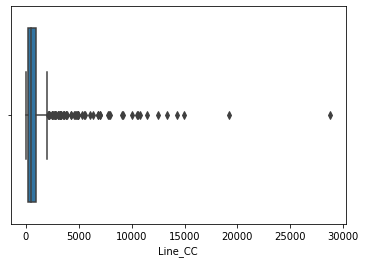

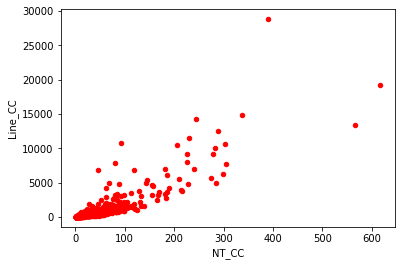

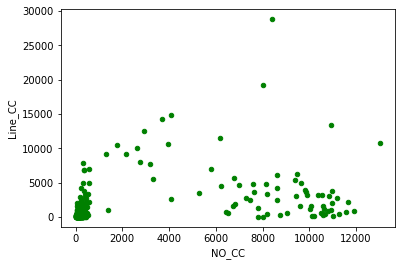

In [6]:
sns.boxplot(x=df[c.LINE_CC])
df.plot.scatter(x=c.NT_CC, y=c.LINE_CC, c='red')
df.plot.scatter(x=c.NO_CC, y=c.LINE_CC, c='green')


In [7]:
# Let's create multiple regression
X = df[[c.NT_CC, c.NO_CC]]
Y = df[c.LINE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)

model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

OLS Regression Results                                
Dep. Variable:                Line_CC   R-squared (uncentered):                   0.749
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              617.2
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                   6.07e-125
Time:                        23:16:47   Log-Likelihood:                         -3595.1
No. Observations:                 416   AIC:                                      7194.
Df Residuals:                     414   BIC:                                      7202.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [8]:
data = {c.OBSERVED:y_test, c.PREDICTED:predictions.round(2), c.DIFFERENCE:abs(y_test - predictions).round(2), c.PERCENT_ERROR:(abs(y_test - predictions)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())
# results

In [9]:
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', model.rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', model.rsquared_adj))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, predictions))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

linux - BUG - Module_CC model performance: 
Model - R Squared: 0.75
Model - R Squared Adj: 0.75
Pred - Mean Absolute Error: 732.15
Pred - Mean Squared Error: 1436214.46
Pred - Root Mean Squared Error: 1198.42
Pred - PRED (25): 12.95%
Pred - PRED (50): 20.86%


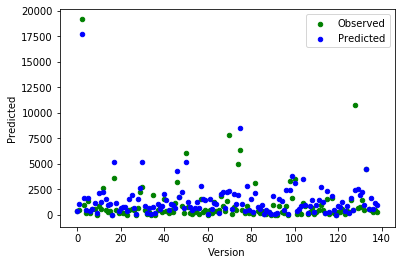

In [10]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

In [11]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [12]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT_CC, fig=regPlotNC)

In [13]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO_CC, fig=regPlotNO)

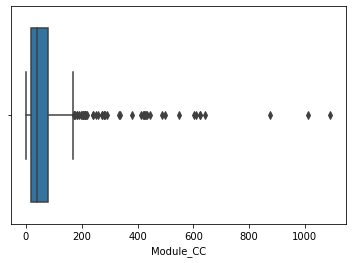

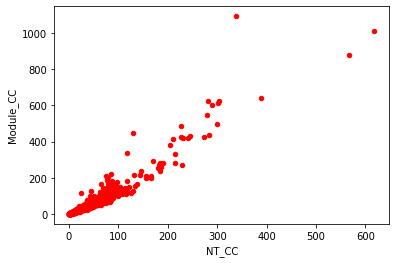

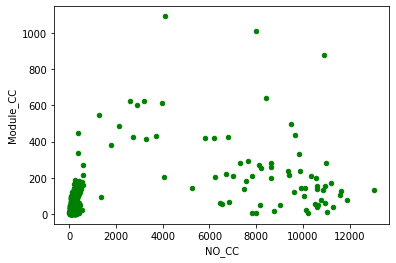

In [14]:
sns.boxplot(x=df[c.MODULE_CC])
df.plot.scatter(x=c.NT_CC, y=c.MODULE_CC, c='red')
df.plot.scatter(x=c.NO_CC,  y=c.MODULE_CC, c='green')


In [15]:
# Let's create multiple regression
X = df[[c.NT_CC, c.NO_CC, c.T_MODULE]]
Y = df[c.MODULE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)

OLS Regression Results                                
Dep. Variable:              Module_CC   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                              1770.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                   2.66e-235
Time:                        23:16:48   Log-Likelihood:                         -2108.1
No. Observations:                 416   AIC:                                      4222.
Df Residuals:                     413   BIC:                                      4234.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [16]:
data = {c.OBSERVED:y_test, c.PREDICTED:predictions.round(2), c.DIFFERENCE:abs(y_test - predictions).round(2), c.PERCENT_ERROR:(abs(y_test - predictions)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())
# results

In [17]:
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', model.rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', model.rsquared_adj))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, predictions))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

linux - BUG - Module_CC model performance: 
Model - R Squared: 0.93
Model - R Squared Adj: 0.93
Pred - Mean Absolute Error: 18.43
Pred - Mean Squared Error: 667.45
Pred - Root Mean Squared Error: 25.84
Pred - PRED (25): 43.17%
Pred - PRED (50): 67.63%


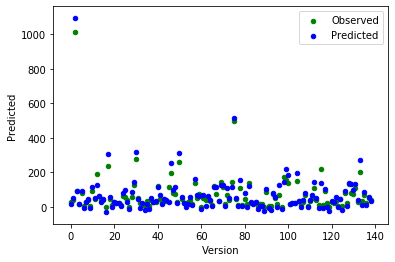

In [18]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

In [19]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [20]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT_CC, fig=regPlotNC)

In [21]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO_CC, fig=regPlotNO)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report

rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train,y_train)
y_pred_rf = rf_regressor.predict(X_test)

# #Cross validation (KFold method)
# y_pred_rf_cross = cross_val_predict(rf_regressor, X, Y, cv=10 )

# #Random Forest Regression Accuracy with cross validation
# accuracy_rf = metrics.r2_score(Y, y_pred_rf_cross)
# print('Cross-Predicted(KFold) Random Forest Regression Accuracy: ', accuracy_rf)

# print(classification_report(y_test, y_pred_rf))

In [23]:
data = {c.OBSERVED:y_test, c.PREDICTED:y_pred_rf.round(2), c.DIFFERENCE:abs(y_test - y_pred_rf).round(2), c.PERCENT_ERROR:(abs(y_test - y_pred_rf)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())

In [24]:
rsquared = rf_regressor.score(X_test,y_test)
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', utils.calculated_rsquared_adj(X, X_test, rsquared)))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred_rf)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, y_pred_rf)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

linux - BUG - Module_CC model performance: 
Model - R Squared: 0.95
Model - R Squared Adj: 0.95
Pred - Mean Absolute Error: 11.55
Pred - Mean Squared Error: 558.64
Pred - Root Mean Squared Error: 23.64
Pred - PRED (25): 66.91%
Pred - PRED (50): 90.65%


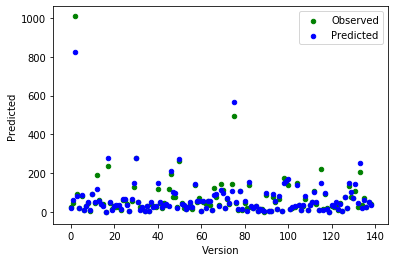

In [25]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

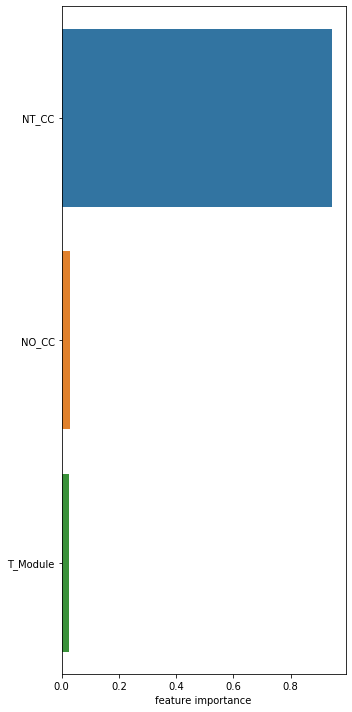

In [26]:
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()